# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# All the traffic image dataset functions are encapuslated into a python class.
# The TrafficDataSet class is used in the entire notebook for reading and exploring
# dataset and also generating augmented dataset.

import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
import cv2
import math
from scipy import ndimage
import random
import matplotlib.pyplot as plt
import csv
import os
from pandas.io.parsers import read_csv

%matplotlib inline

random.seed()

class TrafficImageDataSet(object):
    def __init__(self, train_p, test_p, sign_names_csv):
        with open(train_p, mode='rb') as f:
            self._train = pickle.load(f)
        with open(test_p, mode='rb') as f:
            self._test = pickle.load(f)

        self._read_sign_names(sign_names_csv)

        self._train_f = self._train['features']
        self._train_l = self._train['labels']
        self._test_f = self._test['features']
        self._test_l = self._test['labels']
        self._train_c  = self._train['coords'] 
        self._test_c = self._test['coords']
        self._nclasses = len(np.unique(self._train_l))
        self._generate_augmented_train_dataset()

    def image_shape(self):
        return self._train_f[0].shape
    
    def nclasses(self):
        return self._nclasses
    
    def sign_names(self):
        return self._sign_names
    
    def plot_histogram(self, labels, title):
        labels = labels.tolist()
        samples_count = [labels.count(y) for y in range(self._nclasses)]
        plt.figure(figsize=(12,8))
        plt.bar(range(self._nclasses),height=samples_count)
        plt.ylabel('Total Samples')
        plt.xlabel('Traffic sign class')
        plt.title(title)
        plt.savefig('images/' + title + '.png')

                      
    def grayscale(self, images):
        gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images])
        return gray_images
    
    def normalize(self, images):
        norm_images = (images - np.mean(images))
        norm_images = norm_images / np.std(norm_images)
        return norm_images

    def image_grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    def image_normalize(self, image):
        norm_image = (image - 128) /128
        #norm_image = (image - np.mean(image))
        #norm_image = norm_image / np.std(norm_image)
        return norm_image

    def get_train_coords(self):
        return self._train_c
    
    def get_train_dataset(self):
        return self._train_f, self._train_l
    
    def plot_pre_processed_images(self, num_images):
        images = self._train_f
        labels = self._train_l
        fig, axes = plt.subplots(num_images, 2, figsize=(32, 32))
        axes = axes.ravel()
        #fig.tight_layout()
        for row in range(num_images):
            idx = random.randint(1, images.shape[0])
            image = images[idx]
            axes[row * 2 + 0].axis('off')
            axes[row * 2 + 0].imshow(image)
            axes[row * 2 + 0].set_title(self._sign_names[labels[idx]])
            axes[row * 2 + 1].axis('off')
            image = self._pre_process_image(image)
            image = image.squeeze()
            axes[row * 2 + 1].imshow(image, cmap='gray')
            axes[row * 2 + 1].set_title('gray/histequilized')
                
    def get_test_dataset(self):
        return self._test_f, self._test_l
  
    def get_generated_dataset(self):
        return self._augmented_f, self._augmented_l

    def get_train_validation_dataset(self):
        train_f, train_l = shuffle(self._train_f, self._train_l)
        train_f, validation_f, train_l, validation_l = \
            train_test_split(train_f, train_l, test_size=0.20, random_state=7)
        return train_f, train_l, validation_f, validation_l

    def get_augmented_train_validation_dataset(self):
        augmented_f, augmented_l = self.get_augmented_train_dataset()
        train_f, train_l = shuffle(self._augmented_f, self._augmented_l)
        train_f, validation_f, train_l, validation_l = \
            train_test_split(train_f, train_l, test_size=0.20, random_state=7)
        return train_f, train_l, validation_f, validation_l

    def get_pre_processed_train_dataset(self):
        train_f = self._pre_process_images(self._train_f)
        return train_f, self._train_l
    
    def get_pre_processed_test_dataset(self):
        test_f = self._pre_process_images(self._test_f)
        return test_f, self._test_l
    
    def get_pre_processed_train_validation_dataset(self):
        train_f = self._pre_process_images(self._train_f)
        train_f, train_l = shuffle(train_f, self._train_l)
        train_f, validation_f, train_l, validation_l = \
            train_test_split(train_f, train_l, test_size=0.20, random_state=7)
        return train_f, train_l, validation_f, validation_l
    
    def get_pre_processed_augmented_train_dataset(self):
        augmented_f = self._pre_process_images(self._augmented_f)
        train_f = self._pre_process_images(train_f)
        augmented_f = np.append(np.array(train_f), np.array(augmented_f), axis=0)
        augmented_l = np.append(np.array(self._train_l), np.array(augmented_l), axis=0)
        return augmented_f, augmented_l

    def get_pre_processed_augmented_train_validation_dataset(self):
        augmented_f, augmented_l = self.get_augmented_train_dataset()
        augmented_f = self._pre_process_images(augmented_f)
        train_f, train_l = shuffle(augmented_f, augmented_l)
        train_f, validation_f, train_l, validation_l = \
            train_test_split(train_f, train_l, test_size=0.20, random_state=7)
        return train_f, train_l, validation_f, validation_l
   
    def plot_train_images(self, num_images):        
        self._plot_images(self._train_f, self._train_l, num_images, 'train_images')

    def plot_test_images(self, num_images):        
        self._plot_images(self._test_f, self._test_l, num_images, 'test_images')
        
    def plot_generated_images(self, num_images):        
        #subplots_adjust(left=None, bottom=None, right=None,
        # top=None, wspace=None, hspace=None)
        #left = 0.125  # the left side of the subplots of the figure
        #right = 0.9  # the right side of the subplots of the figure
        #bottom = 0.1  # the bottom of the subplots of the figure
        #top = 0.9  # the top of the subplots of the figure
        #wspace = 0.2  # the amount of width reserved for blank space between subplots
        #hspace = 0.2  # the amount of height reserved for white space between subplots
        #fig.tight_layout()
        images = self._train_f
        labels = self._train_l
        coords = self._train_c
        fig, axes = plt.subplots(num_images, 6, figsize=(32, 32))
        axes = axes.ravel()
        fig.tight_layout()
        for row in range(num_images):
            idx = random.randint(1, images.shape[0])
            image = images[idx]
            axes[row * 6 + 0].axis('off')
            axes[row * 6 + 0].imshow(image)
            axes[row * 6 + 0].set_title(self._sign_names[labels[idx]])

            #scaled_image = self._scale_image(image, coords[idx])
            #axes[row * 6 + 1].axis('off')
            #axes[row * 6 + 1].imshow(scaled_image)
            #axes[row * 6 + 1].set_title('scaled')                
            for col in range(1,6):
                axes[row * 6 + col].axis('off')
                transform_image = self._transform_image(image, coords[idx])
                axes[row * 6 + col].imshow(transform_image)
                axes[row * 6 + col].set_title('shifted/rotated')
        plt.savefig('images/generated_images.png')
        
    def get_additional_images(self, dir_name):
        images = [cv2.imread(dir_name + "/" + name) for name in os.listdir(dir_name)]
        return np.asarray(images)
    
    def get_pre_processed_additional_images(self, dir_name):
        images = self.get_additional_images(dir_name)
        images = self._pre_process_images(images)
        return images
                
    def plot_additional_images(self, dir_name):
        images = self.get_additional_images(dir_name)
        rows, cols = TrafficImageDataSet.get_grid_dim(len(images))
        fig = plt.figure(figsize=(6, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        for i, image in enumerate(images):
            ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
            ax.imshow(image)
        plt.show()        
        
        #fig, axs = plt.subplots(rows, cols, figsize=(5, 5))
        #fig.subplots_adjust(hspace = .2, wspace=.001)
        #fig.tight_layout()
        #axs = axs.ravel()
        #for i, image in enumerate(images):
        #    axs[i].axis('off')
        #    axs[i].imshow(image)
        #plt.savefig('images/web_images.png')
                
    # For perspective transformation, 3x3 transformation matrix is required.
    # Straight lines will remain straight even after the transformation. For finding
    # the transformation matrix, we need 4 points on the input image and corresponding
    # points on the output image. Among these 4 points, 3 of them should not be
    # collinear. The transformation matrix can be found by the function
    # cv2.getPerspectiveTransform. Then apply cv2.warpPerspective with the 3x3
    # transformation matrix.
    def _scale_image(self, img, coords):
        rows, cols, _ = img.shape
        # transform limits
        px = np.random.randint(-2, 2)
        # ending locations
        #(coords[0],coords[1]),coords[2]-coords[0],coords[3]-coords[1]
        # x1,y1,x2,y2
        # [x1,y1], [y2 - y1, x1], [y1, x2-x1], [x2,y2]
        x1,y1,x2,y2 = coords[0], coords[1], coords[2], coords[3] 
        pts1 = np.float32([[x1, y1], [y2-y1, x1], [y1, x2-x1], [x2,y2]])
        #pts1 = np.float32([[px, px], [rows - px, px], [px, cols - px], [rows - px, cols - px]])
        # starting locations (4 corners)
        pts2 = np.float32([[0, 0], [rows, 0], [0, cols], [rows, cols]])
        # pts1 are scale to pts2.
        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(img, M, (rows, cols))
        #dst = dst[:, :, np.newaxis]
        return dst

    def _generate_augmented_train_dataset(self):
        labels = self._train_l.tolist()
        signs = [labels.count(y) for y in range(self._nclasses)]
        #print(signs)
        required_samples = [int(math.ceil(1000 / labels.count(y))) for y in range(self._nclasses)]
        #print(required_samples)
        augmented_f = []
        augmented_l = []
        for idx, label in enumerate(labels, start=0):
            if required_samples[label] > 1:
                #scaled_image = self._scale_image(self._train_f[idx], self._train_c[idx])
                #augmented_f.append(scaled_image)
                #augmented_l.append(label)
                for i in range(required_samples[label]):
                    augmented_f.append(self._transform_image(self._train_f[idx], self._train_c[idx]))
                    augmented_l.append(label)
        self._augmented_f = np.array(augmented_f)
        self._augmented_l = np.array(augmented_l)

    def get_augmented_train_dataset(self):
        augmented_f = np.append(np.array(self._train_f), np.array(self._augmented_f), axis=0)
        augmented_l = np.append(np.array(self._train_l), np.array(self._augmented_l), axis=0)
        return augmented_f, augmented_l

    def _pre_process_images(self, images):
        return np.array([self._pre_process_image(image) for image in images])

    def _pre_process_image(self, image):
        img = self.image_grayscale(image)
        img = cv2.equalizeHist(img)
        #img = self.image_normalize(img)
        img = img[..., np.newaxis]
        return img

    def _read_sign_names(self, signames_file):
        self._sign_names = read_csv(signames_file).values[:, 1]
        print(self._sign_names)
        #with open(signames_file) as f:
        #    reader = csv.DictReader(f)
        #    self._sign_names = [line['SignName'] for line in reader]
            
    def _transform_image(self, img, coords):
        #image = ndimage.interpolation.shift(img, 
        #                                    [random.randrange(-2, 2), 
        #                                     random.randrange(-2, 2), 0])
        #image = ndimage.interpolation.rotate(image, 
        #                                     random.randrange(-10, 10), 
        #                                     reshape=False)
        if random.choice([False, True]):
            image = ndimage.interpolation.shift(img, 
                                                [random.randrange(-2, 2), 
                                                 random.randrange(-2, 2), 0])
        else:
            image = ndimage.interpolation.rotate(img, 
                                                 random.randrange(-10, 10), 
                                                 reshape=False)
        return image
       
    def _plot_images(self, images, labels, num_images, save_file):
        offset = random.randint(1, images.shape[0] - num_images)
        rows, cols = TrafficImageDataSet.get_grid_dim(num_images)
        fig, axes = plt.subplots(rows, cols, figsize=(32, 32))
        axes = axes.ravel()
        fig.tight_layout()
        for i in range(num_images):
            idx = random.randint(1, images.shape[0])
            image = images[idx]
            axes[i].axis('off')
            axes[i].imshow(image)
            axes[i].set_title(self._sign_names[labels[idx]])            
        plt.savefig('images/' + save_file + '.png')

    def get_grid_dim(x):
        """
        Transforms x into product of two integers
        """
        factors = TrafficImageDataSet.prime_powers(x)
        if len(factors) % 2 == 0:
            i = int(len(factors) / 2)
            return factors[i], factors[i - 1]

        i = len(factors) // 2
        return factors[i], factors[i]

    def prime_powers(n):
        """
        Compute the factors of a positive integer
        Algorithm from https://rosettacode.org/wiki/Factors_of_an_integer#Python
        :param n: int
        :return: set
        """
        factors = set()
        for x in range(1, int(math.sqrt(n)) + 1):
            if n % x == 0:
                factors.add(int(x))
                factors.add(int(n // x))
        return sorted(factors)

---
## Step 0: Load The Data

In [2]:
# Load picked data and signal names
dataset = TrafficImageDataSet('train.p', 'test.p', 'signnames.csv')

['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road' 'Slippery road'
 'Road narrows on the right' 'Road work' 'Traffic signals' 'Pedestrians'
 'Children crossing' 'Bicycles crossing' 'Beware of ice/snow'
 'Wild animals crossing' 'End of all speed and passing limits'
 'Turn right ahead' 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vehicles over 3.5 metric tons']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Get test and train data set
train_f, train_l = dataset.get_train_dataset()
print("Training examples {}".format(len(train_f)))
test_f, test_l = dataset.get_test_dataset()
print("Test examples {}".format(len(test_f)))
print("Image shape {}".format(dataset.image_shape()))
print("Number of traffic sign classes {}".format(dataset.nclasses()))

Training examples 39209
Test examples 12630
Image shape (32, 32, 3)
Number of traffic sign classes 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

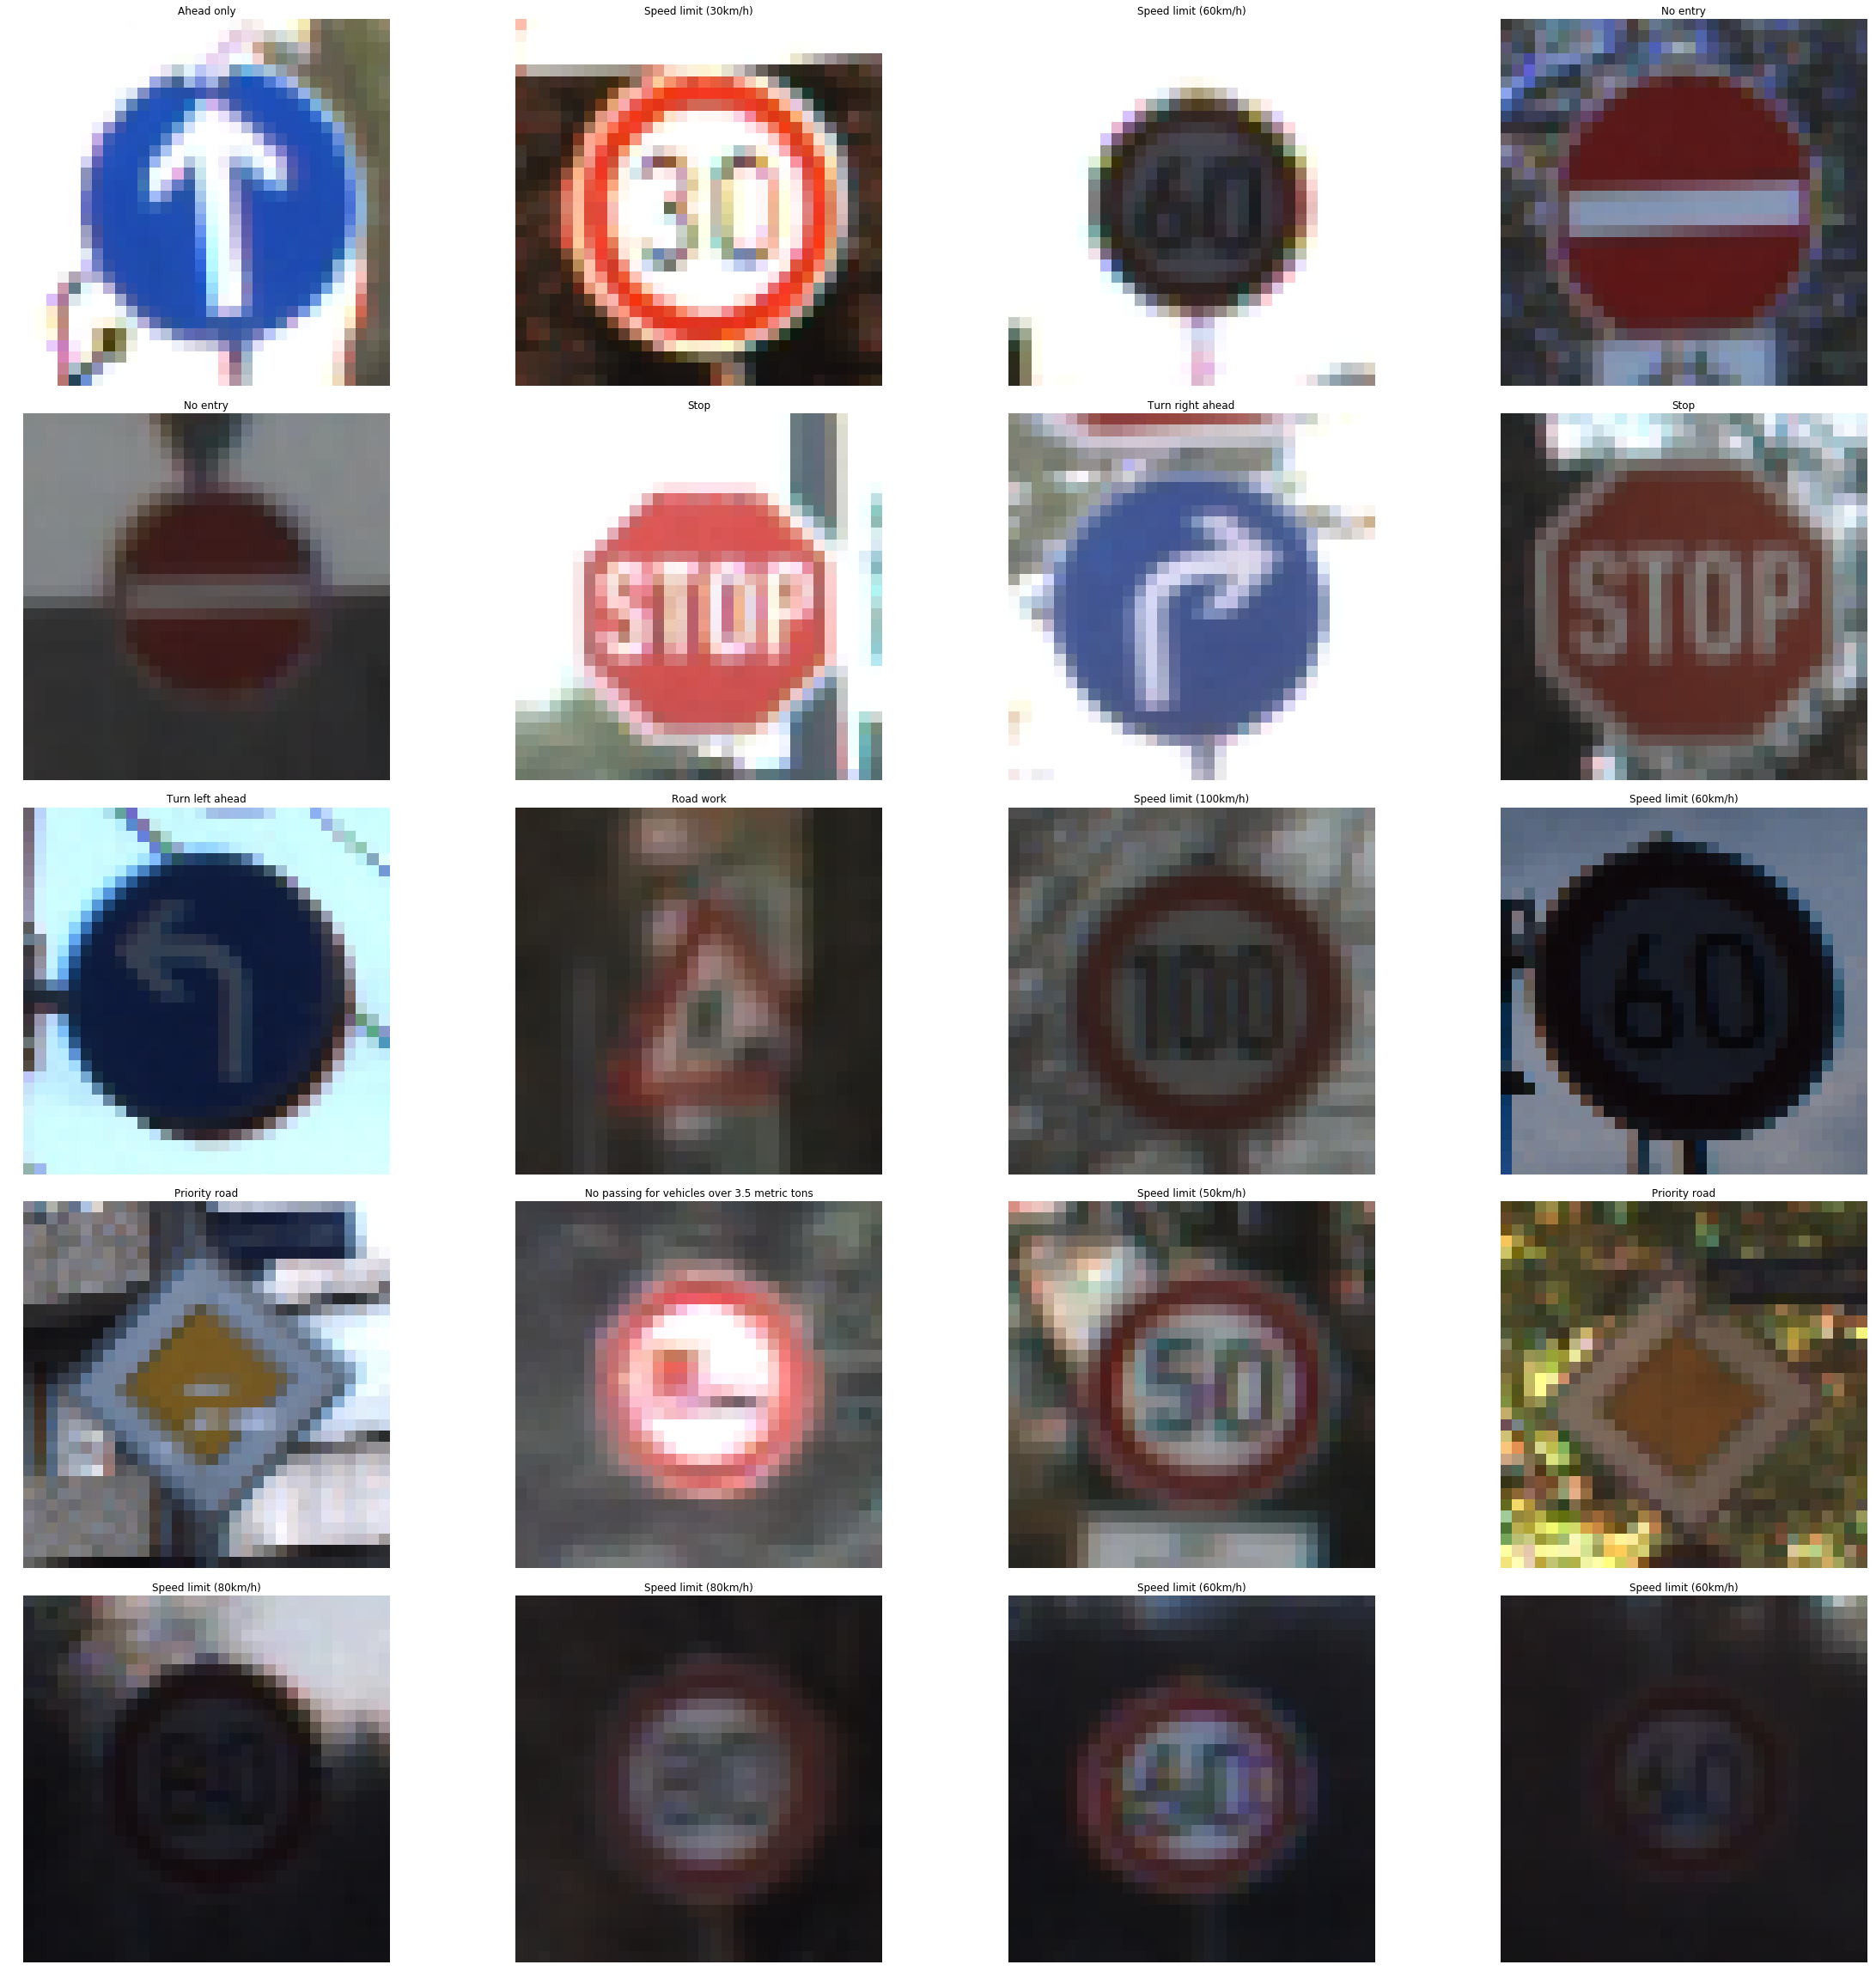

In [4]:
# plot random 20 images from the training data set
dataset.plot_train_images(20)

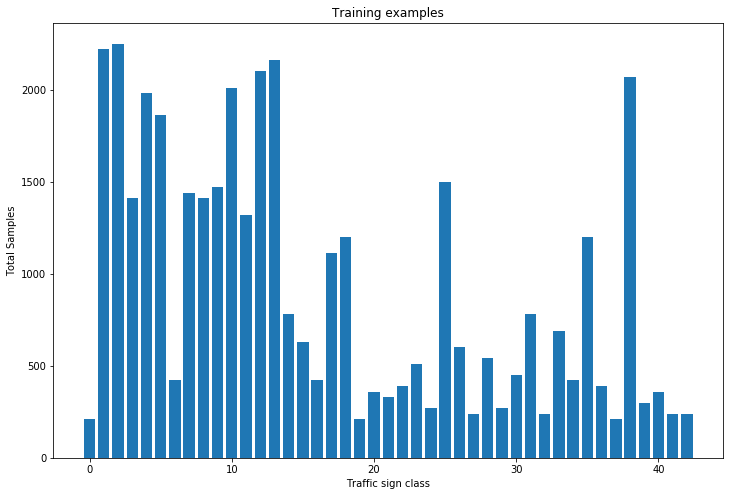

In [5]:
# plot training examples histogram 
dataset.plot_histogram(train_l, "Training examples")

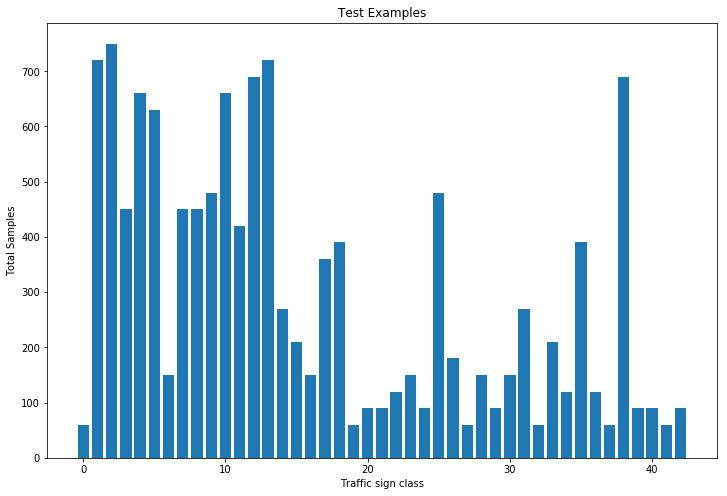

In [6]:
# plot test examples histogram 
dataset.plot_histogram(test_l, 'Test Examples')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
1. Grey scale
2. Histogram equilized.

I used Grey scale with histogram equilization pre processing method. This technique was recommened by senior cohrent udacity students in medium articles. The gray scale image improve the training time where as histogram equilization increases the brightness of the image. Even normalization was also suggested for pre processing the image but for some reason normalized image worsened the validaiton and test accuracy, so i stuck with Gray scale with histogram equilization pre processing method.  

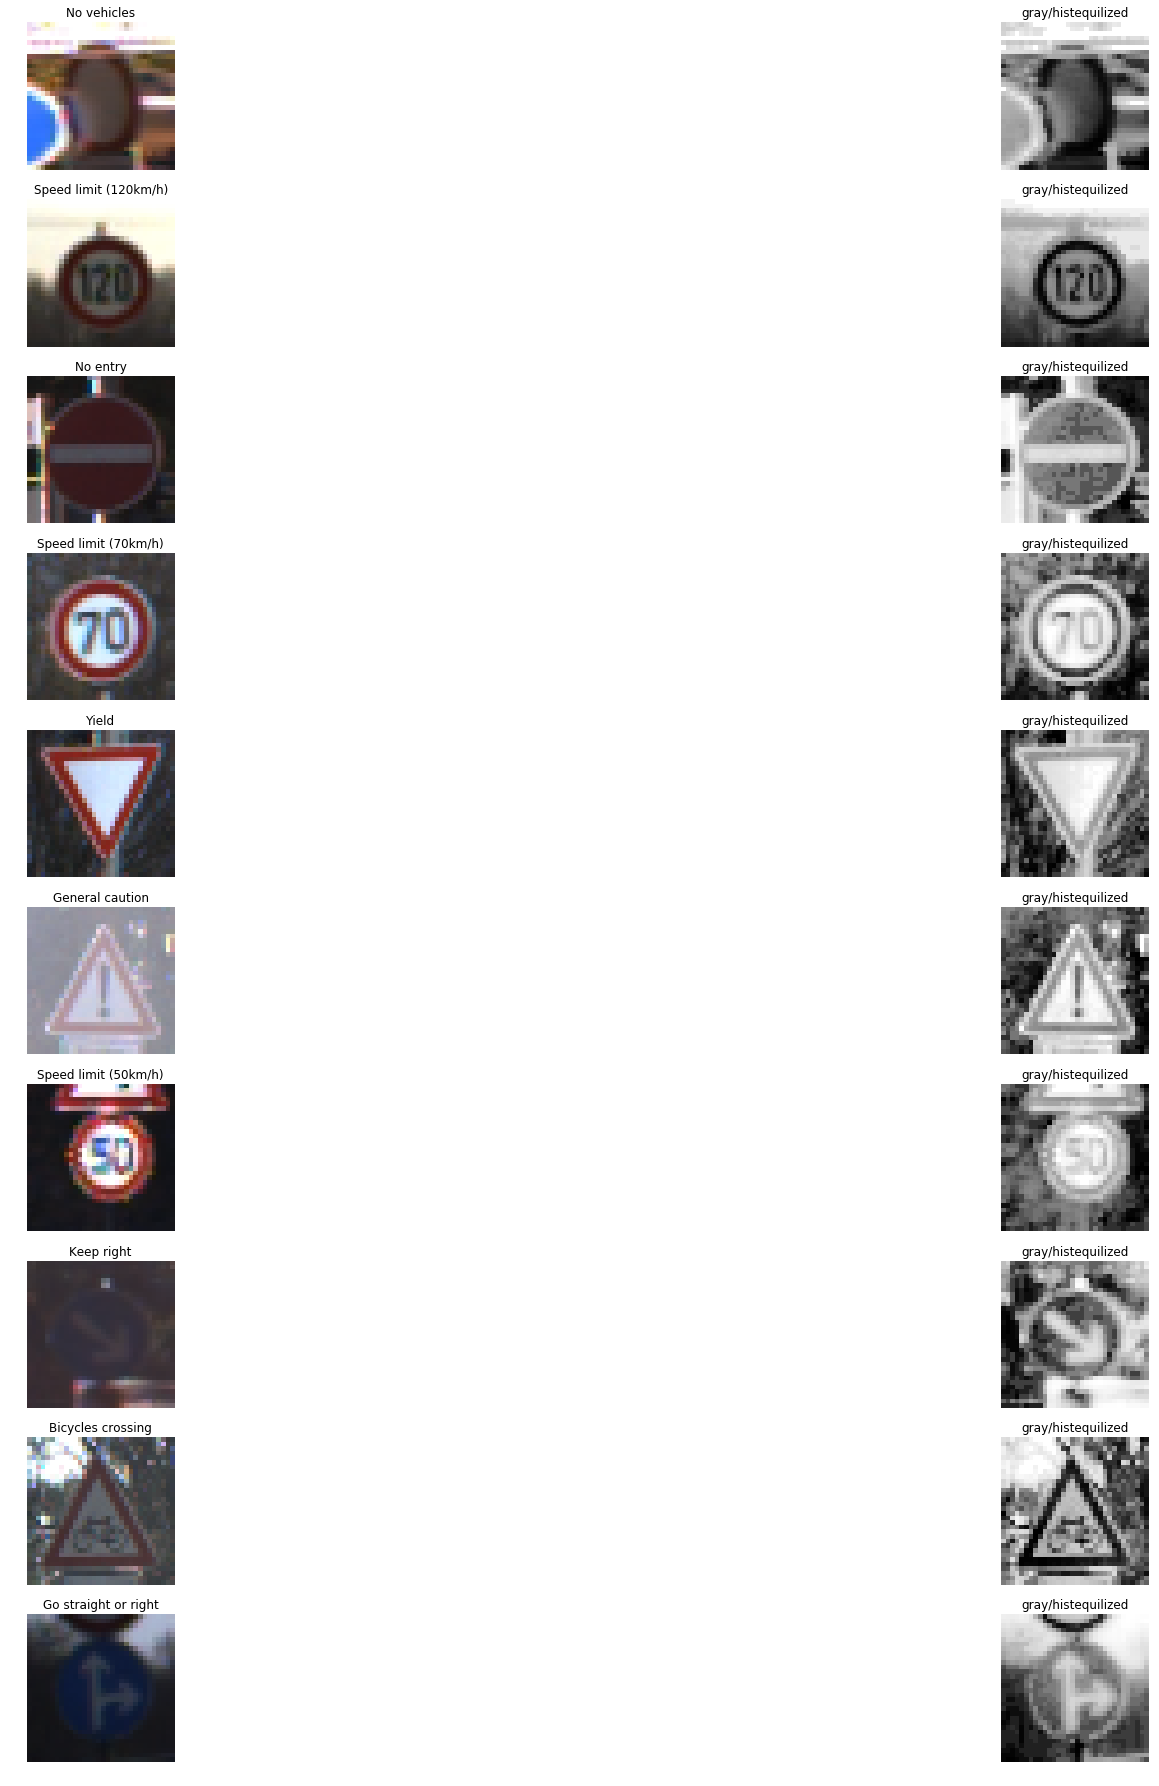

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
dataset.plot_pre_processed_images(10)

In [8]:
train_f, _ = dataset.get_train_dataset()
pre_processed_train_f, _ = dataset.get_pre_processed_train_dataset()
print("orignal image shape {}".format(train_f[0].shape))
print("pre processed image shape {}".format(pre_processed_train_f[0].shape))

orignal image shape (32, 32, 3)
pre processed image shape (32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. The training dataset was split into 80% training dataset and 20% validation dataset.
2. The training dataset is split after pre processing the entire training dataset.
3. The entire pre processed test data set was used.

** Generated Dataset **
1. Generated additional data to improve the validation and test data accuracies. 
2. With out generating additional data, the validation and test data accuracies are 98% and of 91% using the LeNet model.
3. Using generated additional data and tweaking the LeNet model the validation and test data accuracies are 99% and 94.5%.
4. The additional data is generated using random image rotation, random image shift independently.
5. I tried random image rotation and shift as a single image, and scaling the image using the cooridnates in the data set, but didn't observed good improvement in the accuracies.
5. The additional data generating algorithm ensure every traffic sign class has atleast 1000 samples.

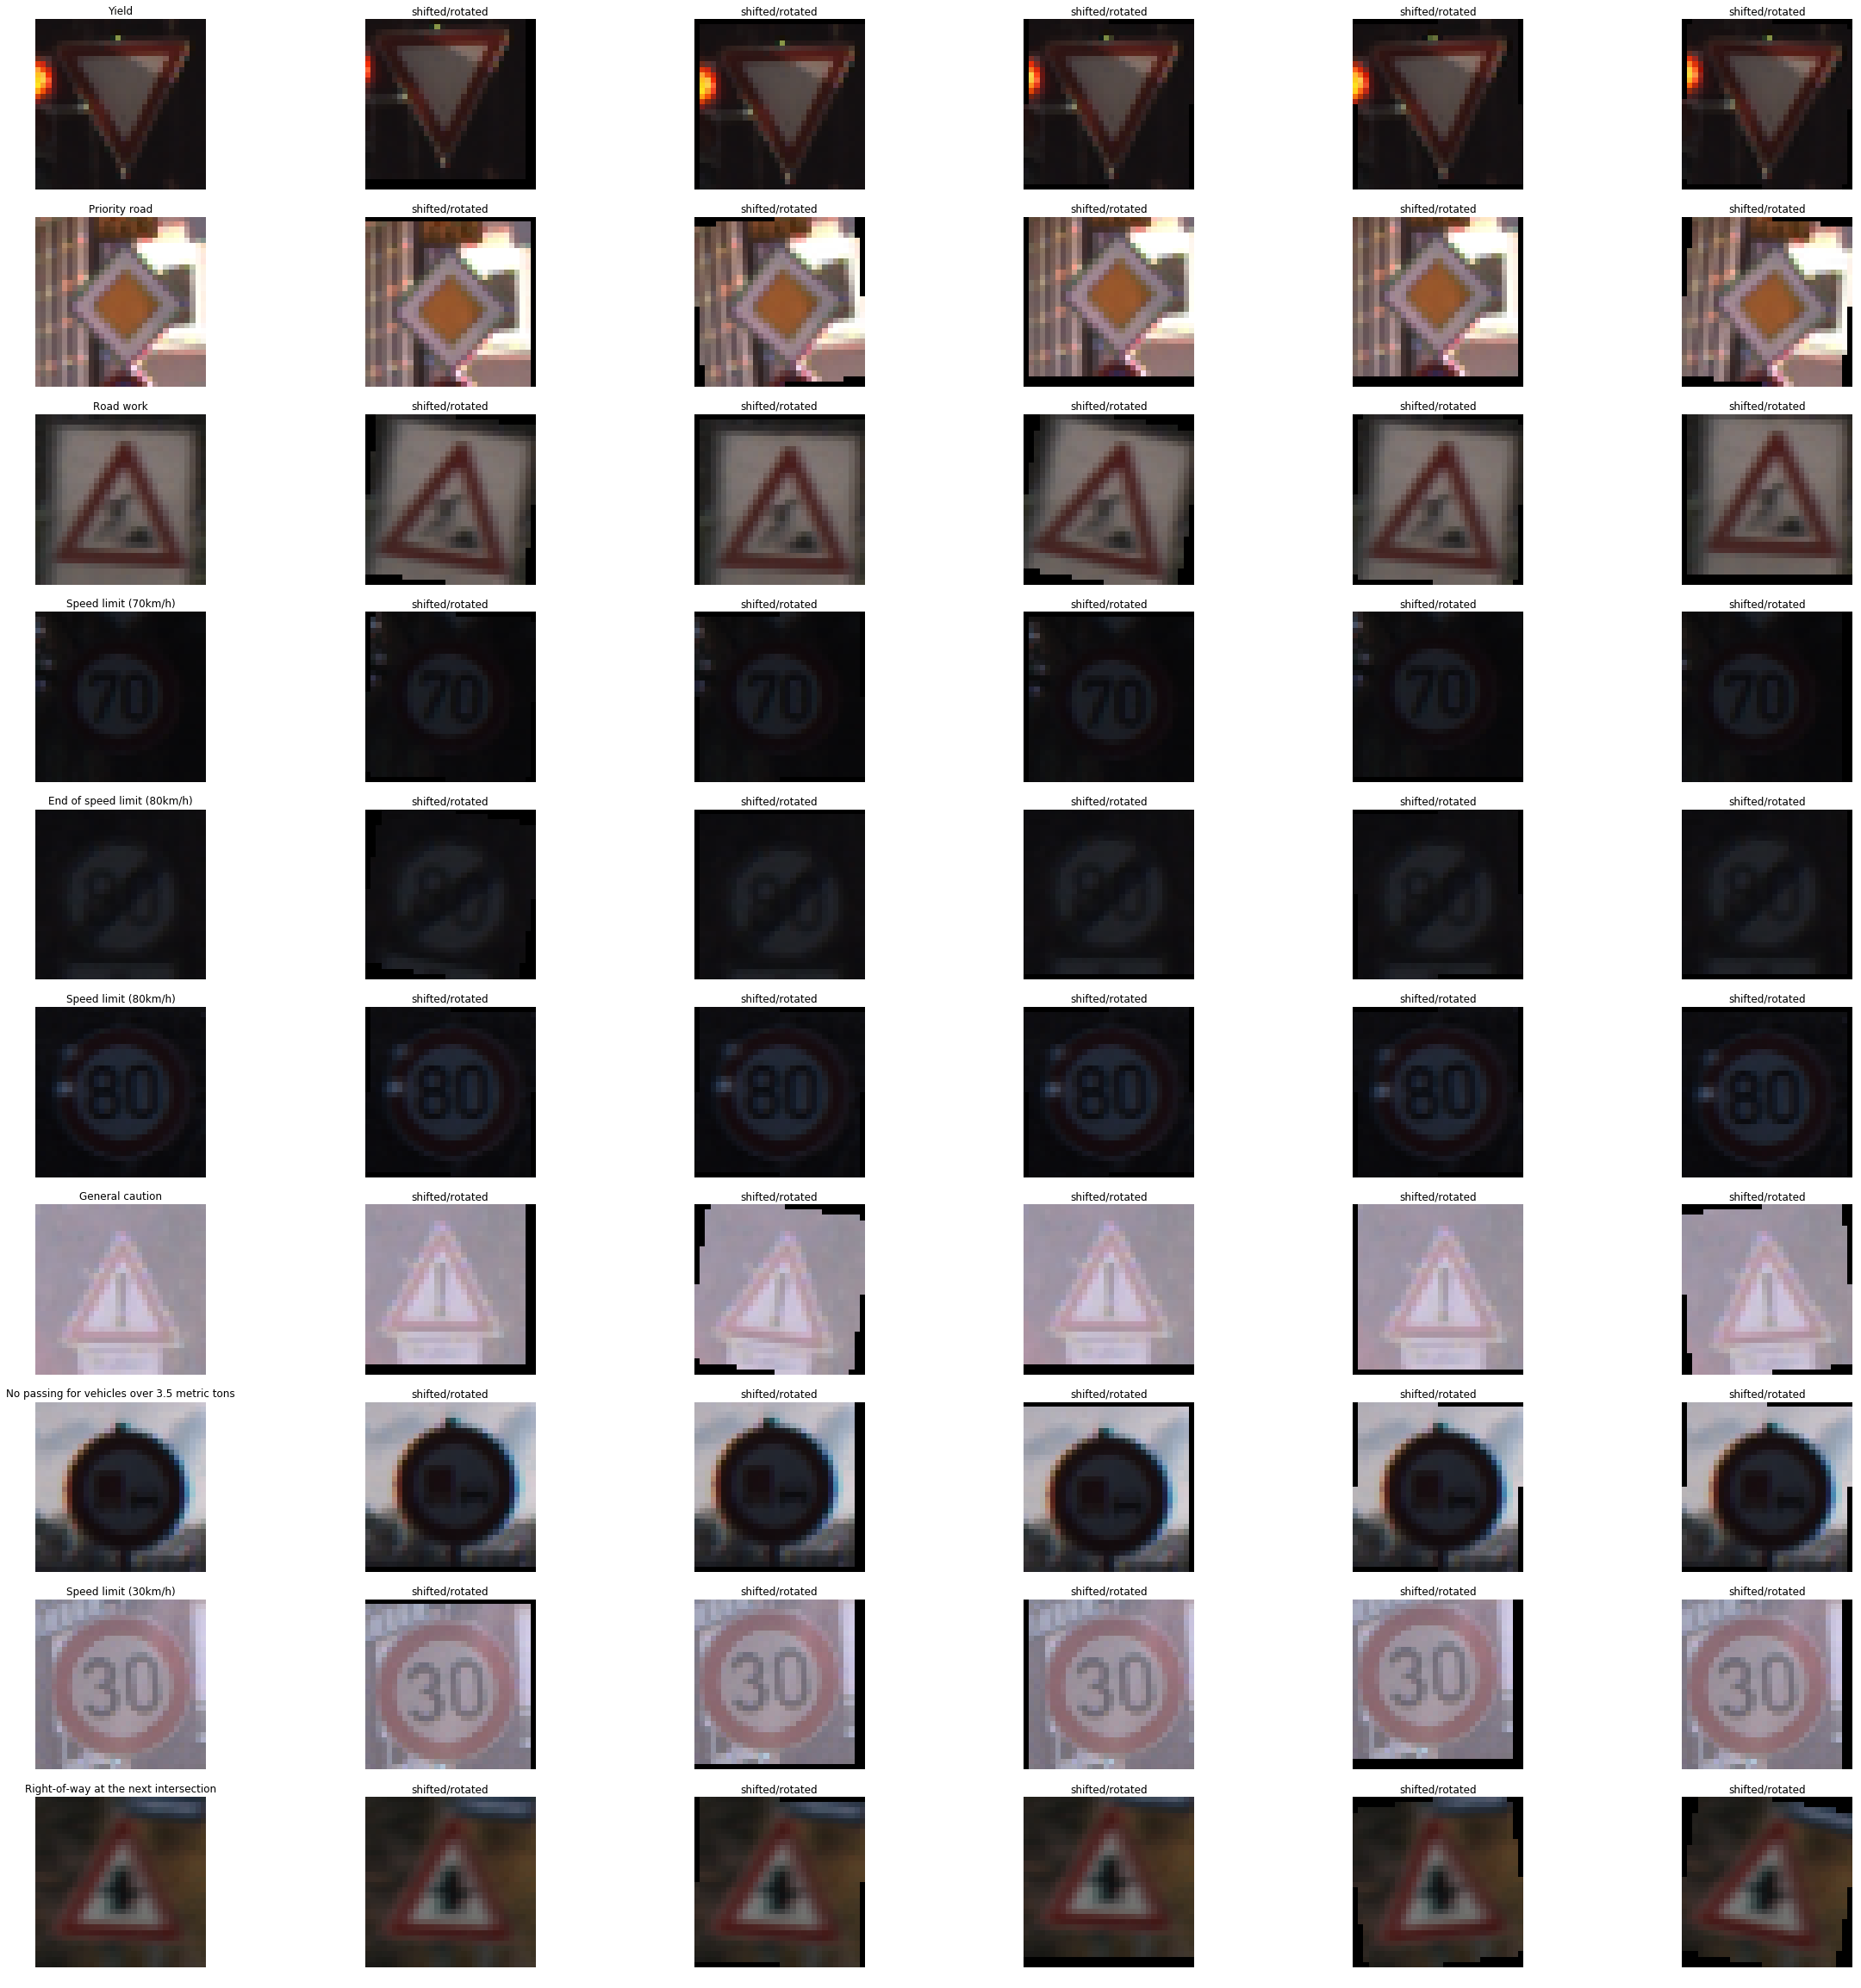

In [9]:
dataset.plot_generated_images(10)

In [10]:
# get generated training examples
generated_f, generated_l = dataset.get_generated_dataset()
print("Generated Training examples {}".format(len(generated_f)))

Generated Training examples 31318


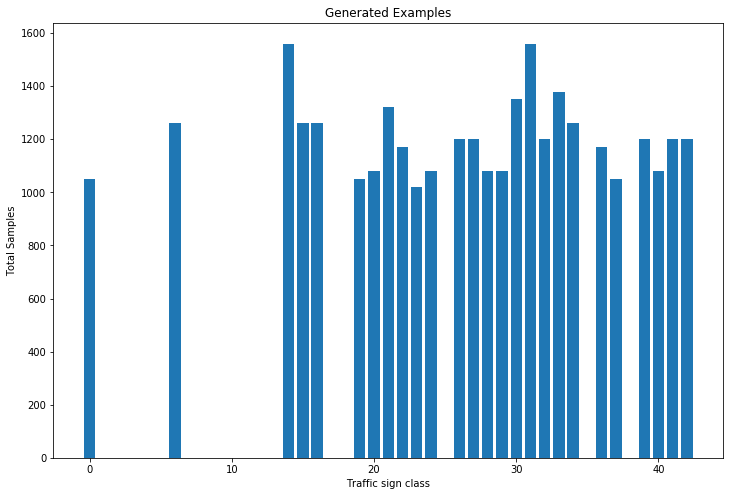

In [11]:
# plot generated examples histogram
dataset.plot_histogram(generated_l, 'Generated Examples')

In [12]:
# get total (train + generated) training examples
train_f, train_l = dataset.get_augmented_train_dataset()
print("Total Training examples {}".format(len(train_f)))

Total Training examples 70527


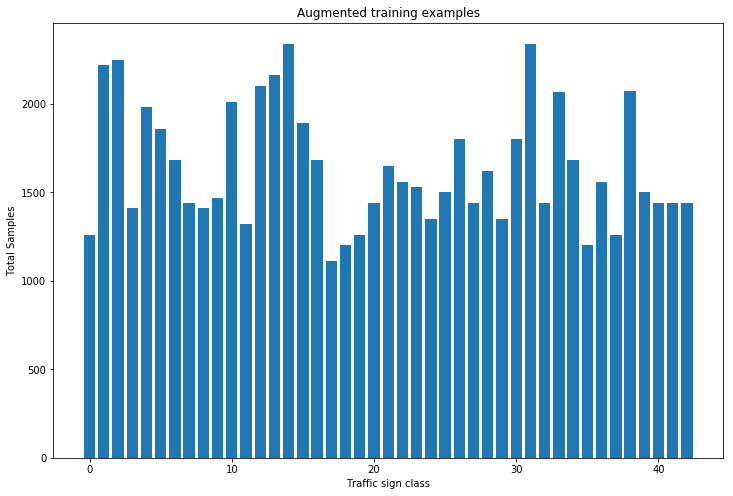

In [13]:
# plot generated examples histogram
dataset.plot_histogram(train_l, "Augmented training examples")

In [14]:
x_train, _, x_validation, _ = dataset.get_pre_processed_augmented_train_validation_dataset()
x_test, _ = dataset.get_pre_processed_test_dataset()
print("training data {}".format(x_train.shape))
print("validation data {}".format(x_validation.shape))
print("test data {}".format(x_test.shape))

training data (56421, 32, 32, 1)
validation data (14106, 32, 32, 1)
test data (12630, 32, 32, 1)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

1.  5x5 convolution (32x32x1 in, 32x32x32 out)
2.  ReLU
3.  4x4 convolution (32x32x32 in, 16x16x64 out)
4.  ReLU
5.  3x3 convolution (16x16x64 in, 8x8x128 out)
6.  ReLU
7.  Flatten (8x8x128 -> 8192)
8.  Fully connected (8192 in -> 512 out)
9.  ReLU
10. Dropout (0.75)
11. Fully connected (512 in -> 256 out)
12. ReLU
13. Dropout (0.75)
14. Fully connected (256 in -> 43) 

In [15]:
# The Model python class encapsulates the following functionalites
# 1. api for adding convolutional neural network layers
# 2. Training the convolutional neural network layers.
# 3. Evaluating the convolutional neural network layers.
# 4. plotting the training and validation accuracy.
# 5. plotting the confusion matrix for test data.
# 6. evlauating additional images.

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
from sklearn.utils import shuffle
import tensorflowvisu
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import numpy
import matplotlib.gridspec as gridspec
import csv
import cv2
import matplotlib.image as mpimg
from sklearn.utils import shuffle
#from pandas_ml import ConfusionMatrix
from matplotlib.ticker import MultipleLocator

class Model(object):
    def __init__(self, input_shape, num_classes):
        tf.set_random_seed(0.0)
        self._x = tf.placeholder(tf.float32, (None,) + input_shape)
        self._nclasses = num_classes
        print('xshape {}'.format(self._x.get_shape()))
        print()
        self._y = tf.placeholder(tf.int32, (None))
        self._one_hot_y = tf.one_hot(self._y, num_classes)
        self._keep_prob = tf.placeholder(tf.float32)
        self._keep_prob_conv = tf.placeholder(tf.float32)
        self._learning_rate = tf.placeholder(tf.float32)
        self._batch_norm_test = tf.placeholder(tf.bool)
        self._batch_norm_iter = tf.placeholder(tf.int32)
        self._activation = None
        self._output = None
        self._cost = None
        self._optimizer = None
        self._correct_predictions = None
        self._test_accuracy = None
        self._test_loss = None
        self._sess = None
        self._saver = None
        self._x_train = self._y_train = self._x_validation = self._y_validation = None
        self._x_test = self._y_test = None
        self._conv_activations = []
        self._dense_activations = []
        self._update_ema = []
        self._dataset = None

        # training accuracy and loss
        self._training_iterations = []
        self._training_accuracy = []
        self._validation_accuracy = []
        self._validation_iterations = []
        self._training_loss = []
        self._validation_loss = []

    def x(self):
        return self._x

    def y(self):
        return self._y

    def one_hot_y(self):
        return self._one_hot_y

    def activation(self):
        return self._activation

    def keep_prob(self):
        return self._keep_prob

    def conv2d(self, ksize, nfeatures, stride=1, dropout=False):

        if self._activation is not None:
            x = self._activation
        else:
            x = self._x

        channels = x.get_shape()[3].value
        print('convd layer input shape {}'.format(x.get_shape()))
        weights = tf.Variable(tf.truncated_normal(shape=[ksize, ksize, channels, nfeatures],
                                                  mean=0,
                                                  stddev=0.1))
        bias = tf.Variable(tf.zeros(nfeatures))

        conv = tf.nn.conv2d(x, weights, strides=[1, stride, stride, 1], padding='SAME')
        conv = tf.nn.bias_add(conv, bias)

        self._activation = tf.nn.relu(conv)

        self._conv_activations.append(tf.reshape(tf.reduce_max(self._activation, [0]), [-1]))

        if dropout:
            self._activation = tf.nn.dropout(self._activation,
                                             self._keep_prob_conv)

        print('convd layer output shape {}'.format(self._activation.get_shape()))
        print()

    def maxpool(self, ksize, stride):
        print('maxpool layer input shape {}'.format(self._activation.get_shape()))
        self._activation = tf.nn.max_pool(self._activation,
                                          ksize=[1, ksize, ksize, 1],
                                          strides=[1, stride, stride, 1],
                                          padding='VALID')
        print('maxpool layer output shape {}'.format(self._activation.get_shape()))
        print()

    def fc(self, nodes, batch_norm=False, dropout=False, act=tf.nn.relu):
        if self._activation is not None:
            x = self._activation
        else:
            x = self._x

        shape = x.get_shape()
        print('fully connected layer input shape {}'.format(shape))
        # if rank of input tensor is greater than 2
        # we need to reshape it
        if shape.ndims > 2:
            n = 1
            for s in shape[1:]:
                n *= s.value
            x = tf.reshape(x, tf.pack([-1, n]))
            x.set_shape([None, n])

        # get number of column in input tensor
        n = x.get_shape()[1].value

        weights = tf.Variable(tf.truncated_normal(shape=[n, nodes],
                                                  mean=0,
                                                  stddev=0.1))

        bias = tf.Variable(tf.zeros(nodes))

        fc = tf.add(tf.matmul(x, weights), bias)

        if act is not None:
            self._activation = act(fc)
            self._dense_activations.append(tf.reshape(tf.reduce_max(self._activation, [0]), [-1]))
        else:
            self._activation = fc

        if dropout:
            self._activation = tf.nn.dropout(self._activation, self._keep_prob)


        print('fully connected layer output shape {}'.format(self._activation.get_shape()))
        print()

    def append_training_data(self, i, a, c):
        self._training_iterations.append(i)
        self._training_accuracy.append(a)
        self._training_loss.append(c)

    def append_validation_data(self, i, a, c):
        self._validation_iterations.append(i)
        self._validation_accuracy.append(a)
        self._validation_loss.append(c)

    def _batch_trainer(self, x_train, y_train, x_validation, y_validation,
                       epochs, batch_size, dropout, conv_dropout):
        self._saver = tf.train.Saver()

        with tf.Session() as self._sess:
            self._sess.run(tf.global_variables_initializer())
            current_epoch = 0
            dataset = DataSet(x_train, y_train, reshape=False)
            i = 0
            while epochs > dataset.epochs_completed:
                batch_x, batch_y = dataset.next_batch(batch_size)
                # Run optimization op (backprop)
                self._sess.run(self._optimizer,
                         feed_dict={self._x: batch_x,
                                    self._y: batch_y,
                                    self._batch_norm_test: False,
                                    self._keep_prob_conv: conv_dropout,
                                    self._keep_prob: dropout})
                i += 1
                
                # compute training accuracy every 20 iterations for visualisation
                if i % 20 == 0:
                    a, c, ca, da = self._sess.run(
                        [self._accuracy, self._cost, self._conv_activations, self._dense_activations],
                        {self._x: batch_x,
                         self._y: batch_y,
                         self._batch_norm_test: False,
                         self._keep_prob_conv: 1.0,
                         self._keep_prob: 1.0})
                    #print("{} : training accuracy {}, loss {}".format(i, a, c))      
                    self.append_training_data(i, a, c)

                # compute validation accuracy every 100 iterations for visualisation
                if i % 100 == 0:
                    a, c = self._evaluate(x_validation, y_validation, batch_size)
                    #print("{} : epoch {} validation accuracy {}, loss {}".format(i, dataset.epochs_completed, a, c))
                    self.append_validation_data(i, a, c)
                    
                if current_epoch != dataset.epochs_completed:
                    current_epoch = dataset.epochs_completed
                    a, c = self._evaluate(x_validation, y_validation, batch_size)
                    print("epoch {} validation accuracy {}, loss {}".format(dataset.epochs_completed, a, c))
                    
            print("\rOptimization Finished!")
            self._saver.save(self._sess, './lenet')

    def train(self,
              x_train,
              y_train,
              x_validation,
              y_validation,
              epochs=10,
              batch_size=128,
              dropout=0.75,
              conv_dropout=1.0):

        learning_rate = 0.001

        # Define loss function
        self._cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self._activation, self._one_hot_y))

        # Define optimizer
        self._optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self._cost)

        # Define accuracy operation
        self._pred_labels_sm = tf.nn.softmax(self._activation)
        self._pred_labels = tf.argmax(self._pred_labels_sm, 1)
        self._correct_prediction = tf.equal(self._pred_labels, tf.argmax(self._one_hot_y, 1))
        self._accuracy = tf.reduce_mean(tf.cast(self._correct_prediction, tf.float32))

        self._x_train = x_train
        self._y_train = y_train
        self._x_validation = x_validation
        self._y_validation = y_validation
        
        self._batch_trainer(x_train, y_train, x_validation, y_validation,
                            epochs, batch_size, dropout, conv_dropout)

    def _evaluate(self, x_data, y_data, batch_size = 128):
        num_examples = len(x_data)
        total_accuracy = 0
        total_cost = 0.
        sess = tf.get_default_session()
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = x_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
            accuracy, cost = sess.run([self._accuracy, self._cost],
                                feed_dict={self._x: batch_x,
                                           self._y: batch_y,
                                           self._keep_prob_conv : 1.0,
                                           self._keep_prob: 1.})
            total_accuracy += (accuracy * len(batch_x))
            total_cost += (cost * len(batch_x))
        return total_accuracy / num_examples, total_cost / num_examples

    def evaluate(self, x_test, y_test):
        with tf.Session() as sess:
            self._saver.restore(sess, tf.train.latest_checkpoint('.'))
            self._test_accuracy, self._test_loss = self._evaluate(x_test, y_test)
            print("Test Accuracy = {:.3f} Test Loss = {:.3f}".format(self._test_accuracy, self._test_loss))

    def print_confusion_matrix(self, x_test, y_test):
        with tf.Session() as sess:
            self._saver.restore(sess, tf.train.latest_checkpoint('.'))
            x_test, y_test = shuffle(x_test, y_test)
            pred_labels = sess.run(self._pred_labels,
                                   feed_dict={self._x: x_test[:4096],
                                              self._y: y_test[:4096],
                                              self._keep_prob_conv: 1.,
                                              self._keep_prob: 1.})

            cm = confusion_matrix(y_true=y_test[:4096], y_pred=pred_labels)
            print(cm)
            fig = plt.figure(fig_size=())
            ax = fig.add_subplot(111)
            cax = ax.matshow(cm)
            plt.title('Confusion matrix of Traffic Sign classifier')
            fig.colorbar(cax)
            ax.set_xticklabels([i for i in range(self._nclasses)])
            ax.xaxis.set_major_locator(MultipleLocator(1))
            ax.yaxis.set_major_locator(MultipleLocator(1))
            ax.set_yticklabels([i for i in range(self._nclasses)])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
                
    def evaluate_additional_images(self, orig_images, images, labels):       
        with tf.Session() as sess:
            self._saver.restore(sess, tf.train.latest_checkpoint('.'))

            topk = tf.nn.top_k(self._pred_labels_sm, 5)

            pred_labels = sess.run(self._pred_labels_sm,
                                   feed_dict={self._x: images,
                                              self._keep_prob_conv: 1.,
                                              self._keep_prob: 1.})

            topk_pred = sess.run([self._pred_labels_sm, topk],
                                  feed_dict={self._x: images,
                                             self._keep_prob_conv: 1.,
                                             self._keep_prob: 1.})

            self.plot_top_k_predictions(topk_pred[1], orig_images, labels)
            return topk_pred[1]
    
    def plot_top_k_predictions(self, topk_pred, images, labels):

        for i, image in enumerate(images):
            # Prepare the grid
            plt.figure(figsize = (6, 2))
            gridspec.GridSpec(1, 2)

            # Plot original image
            plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
            plt.imshow(image.squeeze())
            plt.axis('off')

            # Plot predictions
            plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
            plt.barh(np.arange(5)+.5, 
                     topk_pred[0][i], 
                     align='center')
            plt.yticks(np.arange(5)+.5, 
                       labels[topk_pred[1][i].astype(int)])
            plt.tick_params(axis='both', 
                            which='both', 
                            labelleft='off', 
                            labelright='on', 
                            labeltop='off', 
                            labelbottom='off')

            plt.show()

                    
    def plot_model(self):
        fig = plt.figure(figsize=(19.20,10.80), dpi=70)
        plt.gcf().canvas.set_window_title("Traffic Sign Classifer")
        fig.set_facecolor('#FFFFFF')

        ax1 = fig.add_subplot(231)
        ax2 = fig.add_subplot(232)

        ax1.set_title("Accuracy", y=1.02)
        ax2.set_title("Cross entropy loss", y=1.02)

        ax1.set_ylim(0, 1)  # important: not autoscaled
        ax2.autoscale(axis='y')
        #ax2.set_ylim(0, 5)  # important: not autoscaled

        line1, = ax1.plot(self._training_iterations, self._training_accuracy, label="training accuracy")
        line2, = ax1.plot(self._validation_iterations, self._validation_accuracy, label="validation accuracy")
        legend = ax1.legend(loc='lower right') # fancybox : slightly rounded corners
        legend.draggable(True)

        line3, = ax2.plot(self._training_iterations, self._training_loss, label="training loss")
        line4, = ax2.plot(self._validation_iterations, self._validation_loss, label="validation loss")
        legend = ax2.legend(loc='upper right') # fancybox : slightly rounded corners
        legend.draggable(True)

        line1.set_data(self._training_iterations, self._training_accuracy)
        line2.set_data(self._validation_iterations, self._validation_accuracy)
        line3.set_data(self._training_iterations, self._training_loss)
        line4.set_data(self._validation_iterations, self._validation_loss)

        plt.show()

xshape (?, 32, 32, 1)

convd layer input shape (?, 32, 32, 1)
convd layer output shape (?, 32, 32, 32)

convd layer input shape (?, 32, 32, 32)
convd layer output shape (?, 16, 16, 64)

convd layer input shape (?, 16, 16, 64)
convd layer output shape (?, 8, 8, 128)

fully connected layer input shape (?, 8, 8, 128)
fully connected layer output shape (?, 512)

fully connected layer input shape (?, 512)
fully connected layer output shape (?, 256)

fully connected layer input shape (?, 256)
fully connected layer output shape (?, 43)

epoch 1 validation accuracy 0.9414433575041595, loss 18.58771672080497
epoch 2 validation accuracy 0.9693747341556784, loss 12.179819780114553
epoch 3 validation accuracy 0.9828441797816532, loss 8.47104036573077
epoch 4 validation accuracy 0.9849709343541755, loss 6.74870127001739
epoch 5 validation accuracy 0.9868141216503615, loss 7.4124967901821295
epoch 6 validation accuracy 0.9862469870976889, loss 8.06208544917091
epoch 7 validation accuracy 0.983411314

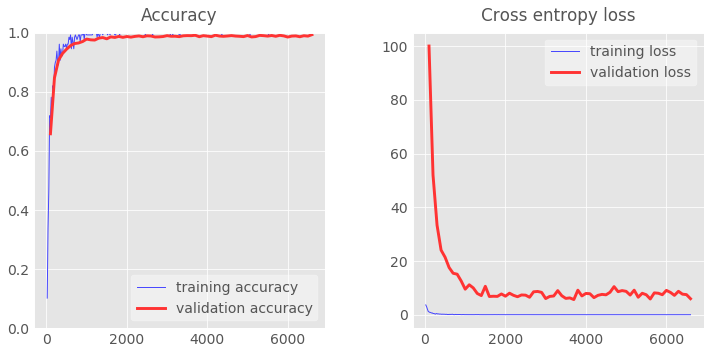

In [21]:
def LeNet(dataset):
    # VA: 98 TA: 92
    n_classes = dataset.nclasses()
    lenet = Model(input_shape=(32,32,1), num_classes=n_classes)
    lenet.conv2d(ksize=5, nfeatures=6)
    lenet.maxpool(ksize=2, stride=2)
    lenet.conv2d(ksize=5, nfeatures=16)
    lenet.maxpool(ksize=2, stride=2)
    lenet.fc(nodes=120, dropout=True)
    lenet.fc(nodes=84, dropout=True)
    lenet.fc(nodes=n_classes, act=None)
    return lenet

def ModifiedLeNet(dataset):
    # VA: 98.8 TA:94.5
    n_classes = dataset.nclasses()
    model = Model(input_shape=(32,32,1), num_classes=n_classes)
    model.conv2d(ksize=5, nfeatures=32)
    model.conv2d(ksize=4, nfeatures=64, stride=2)
    model.conv2d(ksize=3, nfeatures=128, stride=2)
    model.fc(nodes=512, dropout=True)
    model.fc(nodes=256, dropout=True)
    model.fc(nodes=n_classes, act=None)
    return model

#model = LeNetWithAugData(dataset)
model = ModifiedLeNet(dataset)
x_train, y_train, x_validation, y_validation = dataset.get_pre_processed_augmented_train_validation_dataset()
model.train(x_train, y_train, x_validation, y_validation, epochs=15)
model.plot_model()

In [22]:
# run the trained model on the test dataset
x_test, y_test = dataset.get_pre_processed_test_dataset()
model.evaluate(x_test, y_test)

Test Accuracy = 0.952 Test Loss = 52.042


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used AdamOptimizer and experimented with various hyperparameters, including batch size, epochs and various regularisation techniques to prevent overfitting, and ended up using batches of 128 examples and applying dropout to the fully connected layers.

1. Batch size of 128.
2. epochs 15.
3. learning rate of 0.001.
4. drop out in fully connected layer of 0.75.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the basic LeNet model and then tweaked the layers and features based on the following observations.

**Observations:**

** Basic LeNet model without data augmentation **

1. Color images gave validaton accuracy of 97% and test accuracy of 92%.
2. Gray scale images gave validaton accuracy of 97% and test accuracy of 92%.
3. Gray scale with hist equilization gave validation accuracy of 97% and test accuracy of 92%.
4. Gray scale with hist equilization and normalization worsened the validation and test accuracy for some reason.

** Basic LeNet model with data augmentation **

As I haven't observed any improvement in validation and test accuracy with various pre processing method, I tried with data augmentation by ensuring every traffic sign class has atleast 1000 samples. Out of my suprise I didn't observed any improvement. Even with data augmentation in 25 epochs the validation accuracy was 98% and test accuracy was 92%.

** Modified LeNet model with data augmentation **

I tried multiple iterations by tweaking the convulation layers features, adding additional convolutional layers, fully connected layers and remvoing pooling layers. Finally, the following modified LeNet model provided me validation accuracy of 99% and test accuracy of 94-95%.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The candidate images are easily distinguishable from the original dataset. The images are bit brighter and have different colors that the model was not trained on.

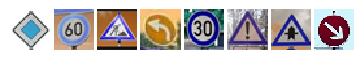

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
dataset.plot_additional_images('./web_images')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model prediction of 62.5% is pretty bad on the captured images compared to the test accuracy of 95%. 

In [24]:
x_web_images = dataset.get_pre_processed_additional_images('./web_images')
y_web_images = [12,3,25,34,1,18,11,30]
model.evaluate(x_web_images, y_web_images)

Test Accuracy = 0.625 Test Loss = 2204.618


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model predicted 6 out of 8 new images correctly with 100% softmax probability. The softmax probability visualization is captured below.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

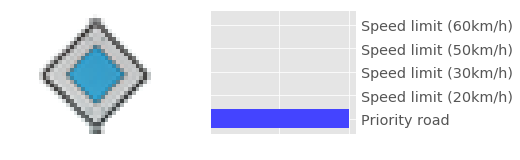

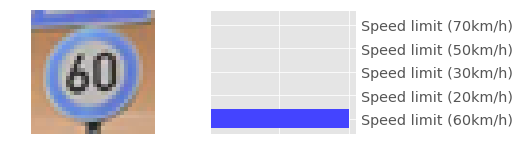

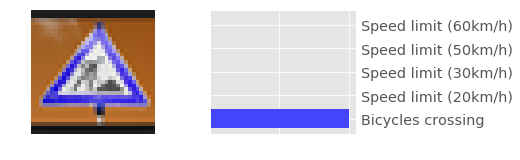

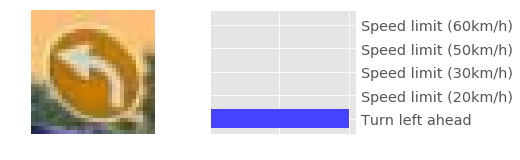

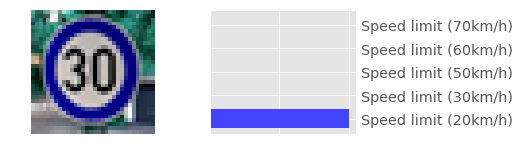

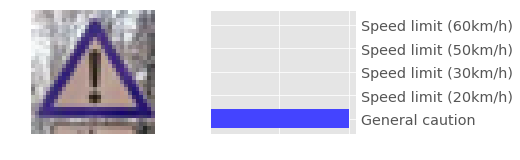

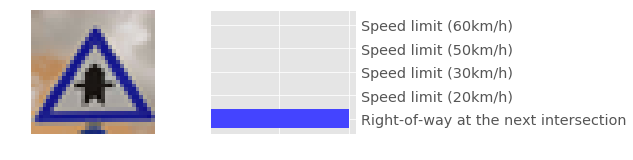

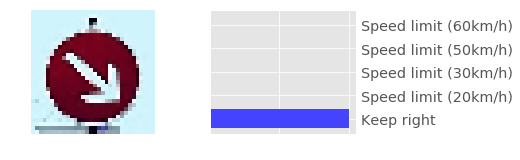

In [25]:
### Visualize the softmax probabilities here.
pred = model.evaluate_additional_images(dataset.get_additional_images('./web_images'), 
                                        dataset.get_pre_processed_additional_images('./web_images'), 
                                        dataset.sign_names())